In [45]:
from torchvision.transforms.functional import to_tensor
from ultralytics import YOLO
from PIL import Image
import torch
import numpy as np

from transformation import detect_objects, draw_boxes, apply_patch_to_image

# Patch image and prediction on the original image

---

In [46]:
image_path = "original_images/persons2.png"
original_image = Image.open(image_path)
original_size = original_image.size

patch_image_path = "patches/exp32.png"
patch = Image.open(patch_image_path)

yolo_model = YOLO("yolov5n.pt")

TARGET_CLASS = "person"
SIZE_MULTIPLE = 0.58

PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



In [47]:
# Step 1: Detect objects
detection_results, resized_size = detect_objects(original_image, yolo_model)


0: 448x640 4 persons, 12.0ms
Speed: 1.0ms preprocess, 12.0ms inference, 6.0ms postprocess per image at shape (1, 3, 448, 640)


In [48]:
# Step 2: Draw boxes on the original image
image_with_boxes = draw_boxes(
    original_image.copy(), detection_results, resized_size, TARGET_CLASS
)
patch_tensor = to_tensor(patch)

In [49]:
# Step 3: Apply the patch to the image
patched_image = apply_patch_to_image(
    original_image.copy(),
    patch_tensor,
    detection_results,
    resized_size,
    TARGET_CLASS,
    size_multiple=SIZE_MULTIPLE,
    patch_position="top"
)

In [50]:
# Display or save the results
image_with_boxes.save("image_with_boxes.jpg")
# patched_image.save("patched_image.jpg")

# Optionally display the images
# image_with_boxes.show()
# patched_image.show()

# Predict on the patched image to test the patch

---

In [51]:
# Step 4: Detect objects in the patched image
patched_detection_results, _ = detect_objects(patched_image, yolo_model)

# Step 5: Draw boxes on the patched image based on the new detections
patched_image_with_boxes = draw_boxes(
    patched_image.copy(), patched_detection_results, resized_size, TARGET_CLASS
)

patched_image_with_boxes.save("patched_image_with_boxes.jpg")
# patched_image_with_boxes.show()

0: 448x640 3 persons, 2 teddy bears, 13.0ms
Speed: 1.0ms preprocess, 13.0ms inference, 5.0ms postprocess per image at shape (1, 3, 448, 640)


In [52]:
# Print detection results for the original image
print("Detection Results on Original Image:")
for i, bbox in enumerate(detection_results.boxes.xyxy):
    class_id = detection_results.boxes.cls[i]
    class_name = detection_results.names[class_id.item() if isinstance(class_id, torch.Tensor) else class_id]
    conf = detection_results.boxes.conf[i]
    print(f"Class: {class_name}, Confidence: {conf:.2f}, Box: {bbox.tolist()}")

# Print detection results for the patched image
print("\nDetection Results on Patched Image:")
for i, bbox in enumerate(patched_detection_results.boxes.xyxy):
    class_id = patched_detection_results.boxes.cls[i]
    class_name = patched_detection_results.names[class_id.item() if isinstance(class_id, torch.Tensor) else class_id]
    conf = patched_detection_results.boxes.conf[i]
    print(f"Class: {class_name}, Confidence: {conf:.2f}, Box: {bbox.tolist()}")


Detection Results on Original Image:
Class: person, Confidence: 0.91, Box: [455.248291015625, 65.06298828125, 560.430908203125, 340.158935546875]
Class: person, Confidence: 0.89, Box: [225.42294311523438, 102.80227661132812, 310.7008361816406, 297.0994873046875]
Class: person, Confidence: 0.86, Box: [328.98187255859375, 116.57815551757812, 406.72857666015625, 331.8382568359375]
Class: person, Confidence: 0.85, Box: [87.94157409667969, 183.49423217773438, 169.9904327392578, 321.8187255859375]

Detection Results on Patched Image:
Class: teddy bear, Confidence: 0.69, Box: [87.99699401855469, 186.6756591796875, 178.6101531982422, 321.8027648925781]
Class: person, Confidence: 0.66, Box: [454.82598876953125, 65.86920166015625, 557.59521484375, 339.49609375]
Class: person, Confidence: 0.60, Box: [329.328857421875, 116.89694213867188, 405.63330078125, 330.1953125]
Class: person, Confidence: 0.55, Box: [455.62158203125, 65.4383544921875, 559.743896484375, 243.36788940429688]
Class: teddy bear, 

In [53]:
original_confidences = [detection_results.boxes.conf[i].item() for i in range(len(detection_results.boxes.xyxy))
                        if detection_results.names[detection_results.boxes.cls[i].item()] == TARGET_CLASS]

patched_confidences = [patched_detection_results.boxes.conf[i].item() for i in range(len(patched_detection_results.boxes.xyxy))
                       if patched_detection_results.names[patched_detection_results.boxes.cls[i].item()] == TARGET_CLASS]

In [54]:
def generate_random_patch(size):
    random_image = Image.fromarray(
        np.random.randint(0, 255, (size[1], size[0], 3), dtype=np.uint8)
    )
    return random_image


random_patch = generate_random_patch(patch.size)
random_patch_tensor = to_tensor(random_patch)

random_patched_image = apply_patch_to_image(
    original_image.copy(),
    random_patch_tensor,
    detection_results,
    resized_size,
    target_class=TARGET_CLASS,
    size_multiple=SIZE_MULTIPLE,
    patch_position="top"
)

random_patched_detection_results, _ = detect_objects(random_patched_image, yolo_model)

random_patched_confidences = [
    random_patched_detection_results.boxes.conf[i].item()
    for i in range(len(random_patched_detection_results.boxes.xyxy))
    if random_patched_detection_results.names[
        random_patched_detection_results.boxes.cls[i].item()
    ]
    == TARGET_CLASS
]


random_patched_image_with_boxes = draw_boxes(
    random_patched_image.copy(),
    random_patched_detection_results,
    resized_size,
    TARGET_CLASS,
)

random_patched_image_with_boxes.save("random_patched_image_with_boxes.jpg")

0: 448x640 4 persons, 15.5ms
Speed: 1.0ms preprocess, 15.5ms inference, 7.5ms postprocess per image at shape (1, 3, 448, 640)


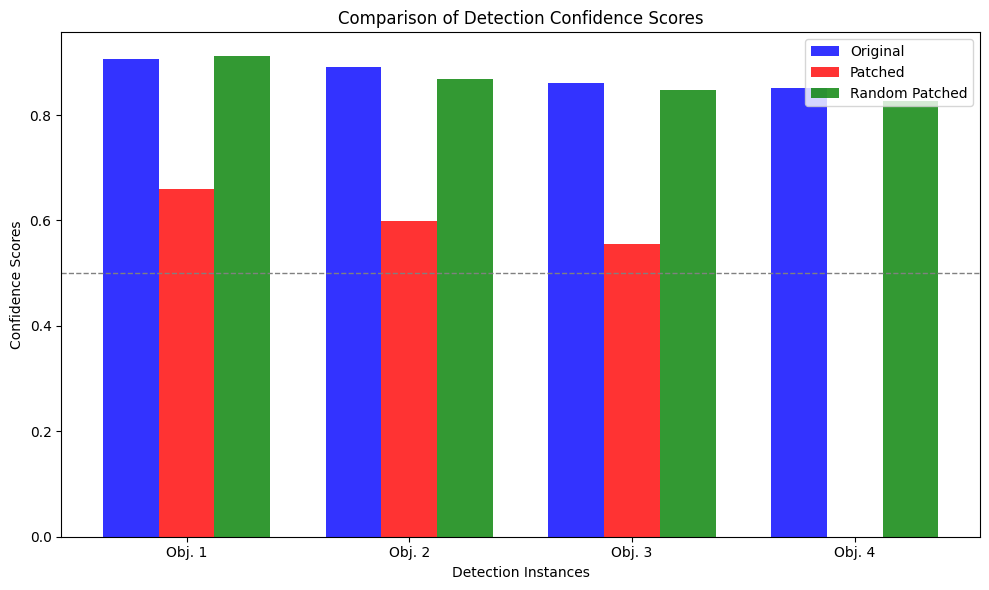

In [55]:
import matplotlib.pyplot as plt

max_len = max(
    len(original_confidences), len(patched_confidences), len(random_patched_confidences)
)
original_confidences += [0] * (max_len - len(original_confidences))
patched_confidences += [0] * (max_len - len(patched_confidences))
random_patched_confidences += [0] * (max_len - len(random_patched_confidences))

indices = np.arange(max_len)

plt.figure(figsize=(10, 6))
bar_width = 0.25
opacity = 0.8

plt.bar(
    indices - bar_width,
    original_confidences,
    bar_width,
    alpha=opacity,
    color="b",
    label="Original",
)
plt.bar(
    indices, patched_confidences, bar_width, alpha=opacity, color="r", label="Patched"
)
plt.bar(
    indices + bar_width,
    random_patched_confidences,
    bar_width,
    alpha=opacity,
    color="g",
    label="Random Patched",
)

plt.axhline(y=0.5, color="gray", linestyle="--", linewidth=1)
plt.xlabel("Detection Instances")
plt.ylabel("Confidence Scores")
plt.title("Comparison of Detection Confidence Scores")
plt.xticks(indices, [f"Obj. {i+1}" for i in indices])
plt.legend()

plt.tight_layout()
plt.show()